# Combining Processed Crop Data
This notebook combines the processed crop data at the country level into a single data file.

In [1]:
import os, json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
import geopandas as gpd
from tools import save_hdf
from tools import CreateLinkAdmin
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

## Combine the processed crop data and shapefile

In [2]:
# Merge crop data
country_iso_list = [
    'AF','AO','BF','CD','GN','KE','LR','LS','MG','ML',
    'MW','MZ','NE','SN','SO','TD','YE','ZA','ZM','ZW',
]
container = []
for country_iso in country_iso_list:
    df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
    if country_iso == 'ZA':
        # South Africa: Combine "Maize (White)" and "Maize (Yellow)" into "Maize"
        cols_raw = df.columns
        df['product'].replace({'Maize (White)': 'Maize', 'Maize (Yellow)': 'Maize'}, inplace=True)
        cols = [
            'fnid', 'country', 'country_code', 'admin_1', 'admin_2', 'name',   
            'season_name', 'planting_year', 'planting_month',
            'harvest_year', 'harvest_month', 'crop_production_system',
        ]
        area = df[df['indicator'] == 'area'].pivot_table(index = cols, columns = 'product', values='value', aggfunc='sum')
        prod = df[df['indicator'] == 'production'].pivot_table(index = cols, columns = 'product', values='value', aggfunc='sum')
        crop = prod/area
        area = area.stack().rename('value').reset_index()
        area['indicator'] = 'area'
        prod = prod.stack().rename('value').reset_index()
        prod['indicator'] = 'production'
        crop = crop.stack().rename('value').reset_index()
        crop['indicator'] = 'yield'
        df = pd.concat([area, prod, crop])[cols_raw]
    container.append(df)
df = pd.concat(container, axis=0).reset_index(drop=True)

# Merge the shapefile used to process the crop data
container = []
path_dir = '../data/shapefile/fewsnet/'
# - Asia
container.append(gpd.read_file(os.path.join(path_dir, 'AF_Admin1_2017.shp'))) # Afghanistan Admin1 in 2017
container.append(gpd.read_file(os.path.join(path_dir, 'YE_Admin1_2014.shp'))) # Yemen Admin1 in 2014
# - East Africa
container.append(gpd.read_file(os.path.join(path_dir, 'BI_Admin1_1998.shp'))) # Brundi Admin1 in 1998
container.append(gpd.read_file(os.path.join(path_dir, 'ET_Admin2_2019.shp'))) # Ethiopia Admin2 in 2019
container.append(gpd.read_file(os.path.join(path_dir, 'KE_Admin1_2009.shp'))) # Kenya Admin1 in 2009
container.append(gpd.read_file(os.path.join(path_dir, 'KE_Admin1_2013.shp'))) # Kenya Admin1 in 2013
container.append(gpd.read_file(os.path.join(path_dir, 'SO_Admin1_1990.shp'))) # Somalia Admin1 in 1990
container.append(gpd.read_file(os.path.join(path_dir, 'SO_Admin2_1990.shp'))) # Somalia Admin2 in 1990
container.append(gpd.read_file(os.path.join(path_dir, 'MG_Admin2_2009.shp'))) # Madagascar Admin2 in 2009
container.append(gpd.read_file(os.path.join(path_dir, 'MW_Admin2_2003.shp'))) # Malawi Admin2 in 2003
container.append(gpd.read_file(os.path.join(path_dir, 'MZ_Admin1_2013.shp'))) # Mozambique Admin1 in 2013
container.append(gpd.read_file(os.path.join(path_dir, 'RW_Admin2_2006.shp'))) # Rwanda Admin2 in 2006
container.append(gpd.read_file(os.path.join(path_dir, 'SS_Admin2_2011.shp'))) # South Sudan Admin2 in 2011
container.append(gpd.read_file(os.path.join(path_dir, 'TZ_Admin1_2012.shp'))) # Tanzania Admin1 in 2012
container.append(gpd.read_file(os.path.join(path_dir, 'UG_Admin2_2007.shp'))) # Uganda Admin2 in 2007
container.append(gpd.read_file(os.path.join(path_dir, 'ZM_Admin2_2011.shp'))) # Zambia Admin2 in 2011
container.append(gpd.read_file(os.path.join(path_dir, 'ZW_Admin1_2011.shp'))) # Zimbabwe Admin1 in 2011
container.append(gpd.read_file(os.path.join(path_dir, 'ZW_Admin2_2011.shp'))) # Zimbabwe Admin2 in 2011
# - Central Africa
container.append(gpd.read_file(os.path.join(path_dir, 'AO_Admin1_2008.shp'))) # Angola Admin1 in 2008
container.append(gpd.read_file(os.path.join(path_dir, 'CM_Admin1_2008.shp'))) # Cameroon Admin1 in 2008
container.append(gpd.read_file(os.path.join(path_dir, 'CF_Admin1_2003.shp'))) # Central African Republic Admin1 in 2003
container.append(gpd.read_file(os.path.join(path_dir, 'TD_Admin1_2012.shp'))) # Chad Admin1 in 2012
container.append(gpd.read_file(os.path.join(path_dir, 'CD_Admin1_2015.shp'))) # Congo Admin1 in 2015
# - North Africa
container.append(gpd.read_file(os.path.join(path_dir, 'MR_Admin1_1990.shp'))) # Mauritania Admin1 in 1990
container.append(gpd.read_file(os.path.join(path_dir, 'SD_Admin1_2013.shp'))) # Sudan Admin1 in 2013
# - West Africa
container.append(gpd.read_file(os.path.join(path_dir, 'BF_Admin2_2001.shp'))) # Burkina Faso Admin2 in 2001
container.append(gpd.read_file(os.path.join(path_dir, 'GN_Admin2_1990.shp'))) # Guinea Admin2 in 1990
container.append(gpd.read_file(os.path.join(path_dir, 'LR_Admin1_2008.shp'))) # Liberia Admin1 in 2008
container.append(gpd.read_file(os.path.join(path_dir, 'ML_Admin1_2016.shp'))) # Mali Admin1 in 2016
container.append(gpd.read_file(os.path.join(path_dir, 'NE_Admin2_2012.shp'))) # Niger Admin2 in 2012
container.append(gpd.read_file(os.path.join(path_dir, 'NG_Admin1_1996.shp'))) # Nigeria Admin1 in 1996
container.append(gpd.read_file(os.path.join(path_dir, 'SN_Admin2_2008.shp'))) # Senegal Admin2 in 2008
container.append(gpd.read_file(os.path.join(path_dir, 'SL_Admin2_1960.shp'))) # Sierra Leone Admin2 in 1960
# - Southern Africa
container.append(gpd.read_file(os.path.join(path_dir, 'LS_Admin1_1980.shp'))) # Lesotho Admin1 in 1980
container.append(gpd.read_file(os.path.join(path_dir, 'ZA_Admin1_1994.shp'))) # South Africa Admin1 in 1994
shape = pd.concat(container, axis=0).reset_index(drop=True)[['FNID','ADMIN0','ADMIN1','ADMIN2','geometry']]
shape = shape.sort_values('FNID').reset_index(drop=True)
shape = shape.to_crs(epsg=4326)
# Manual correction
# Drop a row if FNID is "ZW2011A21503" and ADMIN2 is "Hwange Urban"
shape = shape[~((shape['FNID'] == 'ZW2011A21503') & (shape['ADMIN2'] == 'Hwange Urban'))]
assert len(shape['FNID'].unique()) == shape.shape[0]
# Create country boundary (Admin0)
admin0 = shape.copy(deep=True)
admin0['ADMIN_CODE'] = admin0['FNID'].apply(lambda x: x[:8])
admin0 = admin0.to_crs(epsg=3857)
admin0['geometry'] = admin0['geometry'].buffer(200)
admin0 = admin0.dissolve(by='ADMIN_CODE')
admin0['geometry'] = admin0['geometry'].buffer(-200)
admin0 = admin0.loc[~admin0.index.isin(['KE2009A1','SO1990A1','ZW2011A1']),:]
admin0[['ADMIN1','ADMIN2']] = ''
admin0['FNID'] = admin0.index
admin0['FNID'] = admin0['FNID'].apply(lambda x: x[:-1]+'0')
admin0 = admin0.reset_index(drop=True)
admin0 = admin0.to_crs(epsg=4326)
# Merge
shape = pd.concat([admin0, shape], ignore_index=True).reset_index(drop=True)
shape = shape[['FNID','ADMIN0','ADMIN1','ADMIN2','geometry']]
shape = shape.sort_values(by=['FNID']).reset_index(drop=True)

# Unstable version ------------------------------------------ #
fn_out = '../public/hvstat_data.csv'
df.to_csv(fn_out); print('%s is saved.' % fn_out)
fn_out = '../public/hvstat_shape.gpkg'
shape_simplified = shape.copy()
shape_simplified.geometry = shape_simplified.geometry.simplify(0.001)
shape_simplified.to_file(fn_out, driver='GPKG'); print('%s is saved.' % fn_out)
# ----------------------------------------------------------- #

# # Stable version (public sharing) --------------------------- #
# stable_country_list = ['Burkina Faso', 'Kenya', 'Somalia', 'Malawi']
# # stable_country_list = df['country'].unique()
# stable_data = df[df['country'].isin(stable_country_list)].reset_index(drop=True)
# stable_shape = shape_simplified[shape_simplified['ADMIN0'].isin(stable_country_list)].reset_index(drop=True)
# fn_out = '../public/stable/gscd_data_stable.csv'
# stable_data.to_csv(fn_out); print('%s is saved.' % fn_out)
# fn_out = '../public/stable/gscd_shape_stable.shp'
# stable_shape.to_file(fn_out); print('%s is saved.' % fn_out)
# fn_out = '../public/stable/gscd_shape_stable.json'
# geojson = json.loads(stable_shape.to_json())
# with open(fn_out,'w') as f:
#     f.write(json.dumps(geojson)); print(f'{fn_out} is saved.')
# # ----------------------------------------------------------- #

../public/hvstat_data.csv is saved.
../public/hvstat_shape.gpkg is saved.


## Summary of "adm_crop_production_ALL.hdf"

In [17]:
shape = gpd.read_file('../data/shapefile/adm_shapefile.shp')
df = pd.read_hdf('../data/crop/adm_crop_production_ALL.hdf')
df = df.merge(shape[['FNID','ADMIN0','ADMIN1','ADMIN2']], left_on='fnid', right_on='FNID')
df = df.rename(columns={'ADMIN1':'admin1','ADMIN2':'admin2','season_name':'season'})
df = df[['fnid','country','admin1','admin2','product','season','harvest_month','harvest_year','indicator','value']]
cps = df[['country','product','season']].drop_duplicates().reset_index(drop=True)
df['admin'] = df['fnid'].apply(lambda x: x[2:8])
table = pd.DataFrame(
    index=pd.MultiIndex.from_frame(df[['country','admin','season']].drop_duplicates()),
    columns= cps['product'].unique(),
    data = '-'
).rename_axis(columns='product')
for i, (country_name, product_name, season_name) in cps.iterrows():
    fnids_country = shape.loc[shape['ADMIN0'] == country_name, 'FNID']
    sub = df[
        (df['country'] == country_name) &
        (df['product'] == product_name) &
        (df['season'] == season_name) &
        (df['indicator'] == 'production')
    ]
    if sub.shape[0] > 0:
        count = sub.pivot_table(index='harvest_year', columns='fnid', values='value', aggfunc='count', fill_value=0)
        mean_count = count.sum().mean()
        string = '%d (%d/%d)' %  (mean_count, count.shape[1], len(fnids_country))
    else:
        string = '-'
    table.loc[pd.IndexSlice[country_name,:,season_name],product_name] = string
print('Mean record years (recorded districts / total districts)')
table

Mean record years (recorded districts / total districts)


product                                                         Wheat  \
country                               admin  season                     
Afghanistan                           2017A1 Winter        20 (33/34)   
                                             Spring        20 (33/34)   
Angola                                2008A1 Main            1 (2/18)   
Burkina Faso                          2001A2 Main                   -   
Congo, The Democratic Republic of the 2015A1 Main                   -   
Guinea                                1990A2 Main                   -   
Kenya                                 2013A1 Annual        23 (21/55)   
                                             Long                   -   
                                             Short                  -   
Liberia                               2008A1 Main                   -   
Lesotho                               1980A1 Summer        33 (10/10)   
                                             Winter          6 (6/10)   
Madagascar                            2009A2 Annual                 -   
Mali                                  2016A1 Main           18 (3/11)   
Malawi                                2003A2 Main           5 (16/28)   
                                             Winter          2 (7/28)   
Mozambique                            2013A1 Main harvest    1 (2/11)   
Niger                                 2012A2 Main                   -   
Senegal                               2008A2 Main season            -   
                                             Off season             -   
Somalia                               1990A2 Gu                     -   
                                             Deyr                   -   
                                             Gu-off                 -   
                                             Deyr-off               -   
Chad                                  2012A1 Main           28 (1/23)   
                                             Cold-off               -   
Yemen                                 2014A1 Annual        19 (20/22)   
South Africa                          1994A1 Summer          16 (9/9)   
                                             Winter          39 (9/9)   
Zambia                                2011A2 Annual         6 (34/74)   
Zimbabwe                              2011A1 Main                   -   

product                                                         Maize  \
country                               admin  season                     
Afghanistan                           2017A1 Winter                 -   
                                             Spring                 -   
Angola                                2008A1 Main          26 (18/18)   
Burkina Faso                          2001A2 Main          38 (45/45)   
Congo, The Democratic Republic of the 2015A1 Main           10 (21/0)   
Guinea                                1990A2 Main           8 (31/34)   
Kenya                                 2013A1 Annual        21 (46/55)   
                                             Long          12 (47/55)   
                                             Short          7 (45/55)   
Liberia                               2008A1 Main                   -   
Lesotho                               1980A1 Summer        37 (10/10)   
                                             Winter                 -   
Madagascar                            2009A2 Annual        30 (22/22)   
Mali                                  2016A1 Main           29 (7/11)   
Malawi                                2003A2 Main          38 (28/28)   
                                             Winter        11 (28/28)   
Mozambique                            2013A1 Main harvest  15 (10/11)   
Niger                                 2012A2 Main          13 (42/74)   
Senegal                               2008A2 Main season   35 (41/45)   
                                             Off season  

## Map of processed countries

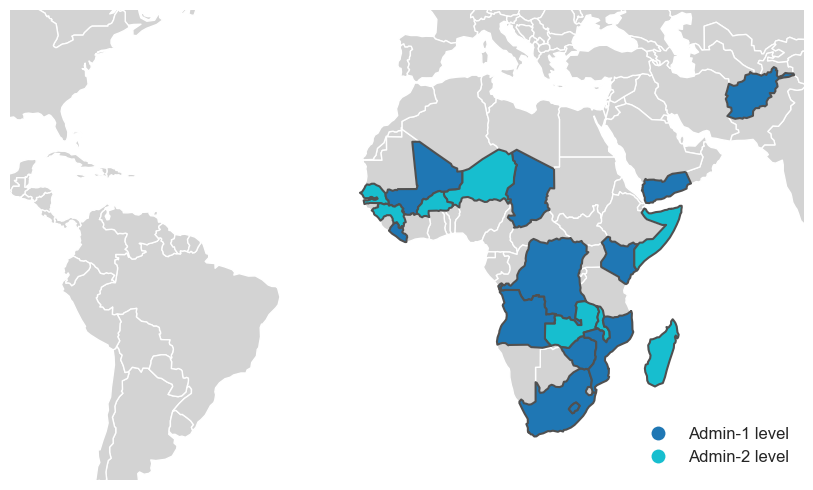

In [18]:
# Little touch on world boundary ---------------------------- #
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
somalia = world[world['name'].isin(['Somalia', 'Somaliland'])].dissolve()
world = pd.concat([world[~world['name'].isin(['Somalia', 'Somaliland'])], somalia], axis=0)
world.replace({'Dem. Rep. Congo':'Congo, The Democratic Republic of the'}, inplace=True)
df = pd.read_hdf('../data/crop/adm_crop_production_ALL.hdf')
# ----------------------------------------------------------- #
df['admin'] = df['fnid'].apply(lambda x: x[7])
country_processed = df[['country','admin']].drop_duplicates()
map_processed = world.merge(country_processed, left_on='name', right_on='country', how='inner')
assert len(map_processed['country'].dropna().unique()) == len(df['country'].unique())
map_processed['admin'] = map_processed['admin'].replace({'1':'Admin-1 level', '2':'Admin-2 level'})

# Plotting
mapdata = map_processed.copy().to_crs('epsg:3857')
sns.set_style("white", {'axes.linewidth': 1, 'grid.color': 'black'})
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), facecolor='w')
ax.set_axis_off()
ax.set_aspect('equal')
ax.axis([-10287412, 8589989, -5174166, 6005999])
world.to_crs('epsg:3857').plot(ax=ax, color='lightgrey')
mapdata.plot(ax=ax, column='admin',linewidth=1.5, edgecolor='#505050', zorder=2,
            categorical=True, legend=True,
            legend_kwds={'loc': 'lower right', 'bbox_to_anchor':(1,0), 'frameon':False, 'fontsize':12},
)
plt.tight_layout()
fig.savefig('../docs/current_status_map.svg',pad_inches=0, bbox_inches='tight', transparent=False)

## (untracked) Somalia - Gu (table format)

In [5]:
# for product_name in ['Maize', 'Sorghum']:
#     df = pd.read_hdf('./data/crop/adm_crop_production_ALL.hdf')
#     df = df[
#         (df['country'] == 'Somalia') &
#         (df['product'] == product_name) &
#         (df['season_name'] == 'Gu')
#     ].reset_index(drop=True)
#     df = df.pivot_table(index='fnid',columns=['indicator','year'],values='value')
#     with pd.ExcelWriter('./public/somalia/adm_crop_production_table_somalia_gu_%s.xlsx' % product_name.lower()) as writer:  
#         df['production'].to_excel(writer, sheet_name='quantity_produced')
#         df['area'].to_excel(writer, sheet_name='harvested_area')
#         df['yield'].to_excel(writer, sheet_name='yield')

## (untracked) Export to public data folder

In [6]:
# # Weston's Google Drive
# shape = gpd.read_file('./data/shapefile/adm_current.shp')
# df = pd.read_hdf('./data/crop/adm_crop_production_ALL.hdf')
# df = df.merge(shape[['FNID','ADMIN0','ADMIN1','ADMIN2']], left_on='fnid', right_on='FNID')
# df = df.rename(columns={'ADMIN1':'admin1','ADMIN2':'admin2','season_name':'season'})
# df = df[['fnid','country','admin1','admin2','product','season','harvest_end','year','indicator','value']]
# df = df[
#     (df['season'].isin(['Gu','Deyr','Long','Short','Main'])) &
#     (df['product'].isin(['Maize','Wheat','Sorghum']))
# ].reset_index(drop=True)
# cps = df[['country','product','season']].drop_duplicates()
# print(cps)
# df_yield = df[df['indicator'] == 'yield']
# df_yield = df_yield.pivot_table(index=['fnid','country','admin1','admin2','product','season','harvest_end','indicator'], columns='year', values='value')
# df_yield = df_yield.astype(np.float32).round(3)
# fn_out = './public/grain_yield_africa.csv'
# df_yield.to_csv(fn_out)
# print("%s is saved." % fn_out)
# fn_out = './public/grain_pay_africa.csv'
# df.to_csv(fn_out)
# print("%s is saved." % fn_out)
# shape.to_file('./public/admin_africa.shp')
# print('./public/admin_africa.shp is saved.')

## (Untrackted) Binary availabililty table

In [7]:
# sub = df[df['indicator'] == 'production']
# table = sub.pivot_table(index=['country','season_name','product','planting_month','harvest_month','fnid'],columns='harvest_year',values='value',aggfunc='count')
# table[table.isna()] = 0
# table[table > 0] = 1
# table = table.astype(np.int)
# table.to_csv('./data/crop/binary_availability.csv')